# **Fotometria**
#### Aquí realizaremos fotometría a imágenes con información astrométrica

Empezamos importando todo lo necesario.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import utilidades

from astropy.io import fits
from astropy.table import Table, QTable
from astropy.stats import sigma_clipped_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS, utils
from astropy.visualization import ImageNormalize, ZScaleInterval

# ccdproc >v2.0
from ccdproc import ImageFileCollection
from photutils import aperture_photometry,SkyCircularAperture, SkyCircularAnnulus, DAOStarFinder

# reproject >v0.6 
from reproject import mosaicking, reproject_interp

Vemos que hay en el directorio

In [2]:
ls

Astrometria.ipynb  default.sex       Imagenes_wcs/    README.md
coords.ecsv        fotometria.csv    images_prop.dat  Tablas/
default.conv       Fotometria.ipynb  mosaico.fits     utilidades.py
default.param      Imagenes/         __pycache__/


### Mapa de las imágenes

In [3]:
carpeta = 'Imagenes_wcs/'
imagenes = ImageFileCollection(carpeta, keywords=['*'])

#### Podemos ver cualquier keyword de los headers

In [4]:
imagenes.summary['file','date-obs', 'mjd-obs', 'filter', 'gain'][:5]

file,date-obs,mjd-obs,filter,gain
str12,str23,float64,str5,float64
Vv0001w.fits,2019-09-30T00:43:27.984,58756.030185,(3) V,2.2
Vv0002w.fits,2019-09-30T00:46:44.026,58756.032454,(3) V,2.2
Vv0003w.fits,2019-09-30T00:52:17.962,58756.036319,(3) V,2.2
Vv0004w.fits,2019-09-30T00:53:54.989,58756.037442,(3) V,2.2
Vv0005w.fits,2019-09-30T00:55:32.016,58756.038565,(3) V,2.2


## Buscando fuentes

Armamos una lista de los hdus para luego armar un mosaico

In [5]:
hdus_l=[]
for hdu in imagenes.hdus(imagetyp='object'):
    hdus_l.append(hdu)

La siguiente funcion devuelve el wcs optimo para la lista de imágenes

In [6]:
wcs_optimo, shape=mosaicking.find_optimal_celestial_wcs(hdus_l)
wcs_optimo.array_shape=shape

Tomo una muestra aleatoria de 50 imagenes para armar un mosaico

In [7]:
hdus_l50 = random.sample(hdus_l, k=50)

El siguiente paso arma el mosaico de las 50 imagenes con el wcs optimo antes encontrado

In [8]:
mosaico_entero, mosaico_huella=mosaicking.reproject_and_coadd(hdus_l50,
                             output_projection=wcs_optimo,
                             reproject_function=reproject_interp,
                             shape_out=shape)

/home/tomas/anaconda3/lib/python3.7/site-packages/reproject/mosaicking/coadd.py:213: RuntimeWarning: divide by zero encountered in true_divide
  final_array /= final_footprint


Armo el mosaico de tan manera de quedarme solo con los pixeles que comparten las 50 imágenes 

In [9]:
huella_mascara=np.ma.masked_not_equal(mosaico_huella,len(hdus_l50))
mask=huella_mascara.mask
mosaico_enmascarado=np.ma.array(mosaico_entero,mask=mask,fill_value=np.nan)
mosaico_data=mosaico_enmascarado.filled()

In [10]:
mosaico_hdr=wcs_optimo.to_header()
mosaico_hdu=fits.PrimaryHDU(data=mosaico_data, header=mosaico_hdr)

Guardo el mosaico en el directorio

In [11]:
mosaico_hdu.writeto('mosaico.fits', overwrite=True,)

In [5]:
# Descomentar si ya se tiene el mosaico desde antes
image='mosaico.fits'
with fits.open(image) as hdul:
    hdr = hdul[0].header
    wcs_optimo = WCS(hdul[0].header)
    mosaico_data = hdul[0].data

#### Calculo la media y desviación estandar del mosaico

In [6]:
mosaico_mean,_ ,mosaico_std = sigma_clipped_stats(mosaico_data)

#### Parametro FWHM de la tabla "images_prop.dat"

In [7]:
stats_table=Table.read('images_prop.dat',format='ascii')
fwhm, _, _, = sigma_clipped_stats(stats_table['fwhm'], sigma=2)
print('fwhm = {:.1f}'.format(fwhm))

fwhm = 8.4


#### Paso a buscar las fuentes con DAOStarFinder

In [8]:
daofind = DAOStarFinder(fwhm=fwhm,threshold=30*mosaico_std)
fuentes = daofind(mosaico_data-mosaico_mean)
fuentes

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,304.5565429789795,98.90386513016747,0.4200040033340992,0.1605706249372115,-0.12234739421478946,121,0.0,69.40167737104176,1.5878329181872366,-0.5020120032142663
2,109.98369567564404,117.33486446640191,0.44397744207041295,0.6852720798048524,0.20122673807278396,121,0.0,32.482237556987116,1.0046925586728515,-0.005082964095905371
3,850.1722446609801,181.19297403255757,0.44424291498066787,0.03200879257708388,-0.15299075544520951,121,0.0,222.15649405598688,5.262571512611766,-1.8029950261813577
4,990.0539439690773,201.35402302544597,0.7162960181196277,0.6979780132065676,-0.7655325412017125,121,0.0,92.27280382134447,2.0283245374738845,-0.7678436113151024
5,332.843591650296,204.8208185797584,0.4402171322322934,0.079658566277343,-0.1360207679249988,121,0.0,3231.0217568049397,73.81829006278721,-4.670409952294826
6,395.781618998088,221.09525985262326,0.21442329281447603,0.13199508543837274,0.4418429472842318,121,0.0,21.468558364555548,1.0255289682788442,-0.027369831156294745
7,149.34741131088836,248.98987550489105,0.40150118200183,0.4968409374728349,0.46098964496149725,121,0.0,36.74740561146808,1.1390464700074732,-0.1413536061945361
8,278.0639693652073,295.8828762826159,0.44283516018486363,0.05118338247417026,-0.1445588341271099,121,0.0,976.1975092721182,22.555349322079103,-3.383123893866586
9,543.9570302491575,326.3577263034369,0.6341472821506566,-0.10089153619509383,0.46405372071023443,121,0.0,56.276964587768475,1.3245417355860651,-0.30516411807644517


#### Graficamos dichas fuentes en color rojo

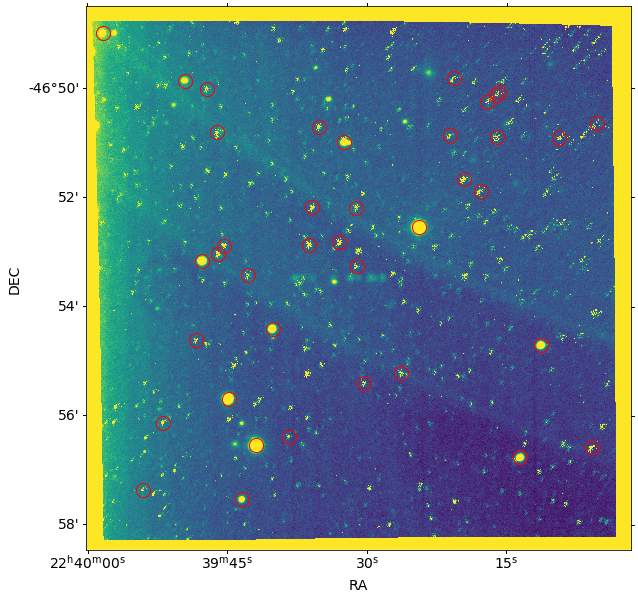

In [9]:
interval=ZScaleInterval()
vmin, vmax = interval.get_limits(mosaico_data)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.subplot(projection=wcs_optimo)

img = ax.imshow(mosaico_data, origin='lower', norm=norm)
ptos = ax.scatter('xcentroid','ycentroid',s=200,edgecolor='r',facecolor=(1,1,1,0.),data=fuentes)
ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)
ax.tick_params(labelsize=14)
plt.show()

#### Armo una QTable con los nombres de las fuentes y sus coordenadas. La guardo en directorio de trabajo.
La tabla queda guardada en formato ECSV que es un CSV con meta data

In [10]:
ind = ['s'+str(idx) for idx in fuentes['id']]
sk = utils.pixel_to_skycoord(fuentes['xcentroid'], fuentes['ycentroid'], wcs=wcs_optimo)
coords = QTable([ind,sk],names=('id','skycoord'))
coords.write('coords.ecsv', overwrite=True)
coords[:5]

id,skycoord
,"deg,deg"
str3,object
s1,"339.9309116332097,-46.95896346604986"
s2,"339.9753472928264,-46.95607035548032"
s3,"339.8063180584209,-46.946100185950634"
s4,"339.774384859963,-46.94292648511229"
s5,"339.9244439002713,-46.9424540551947"


## Fotometría

#### Ya sabemos donde estan las fuentes a las que queremos hacerles fotometría. Ahora vamos a definir las aperturas usando el parametro FWHM segun Howell et. al. 1989

In [11]:
aperturas = SkyCircularAperture(coords['skycoord'], r=fwhm*1.5*u.pix)
anillos = SkyCircularAnnulus(coords['skycoord'], r_in=fwhm*3*u.pix, r_out=fwhm*5*u.pix)

In [13]:
imagen_prueba = 'Imagenes_wcs/Vv0001w.fits'
with fits.open(imagen_prueba) as hdul:
    hdul.info()
    hdr = hdul[0].header
    data = hdul[0].data
    wcs = WCS(hdr)

Filename: Imagenes_wcs/Vv0001w.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     178   (1024, 1024)   int16 (rescales to uint16)   


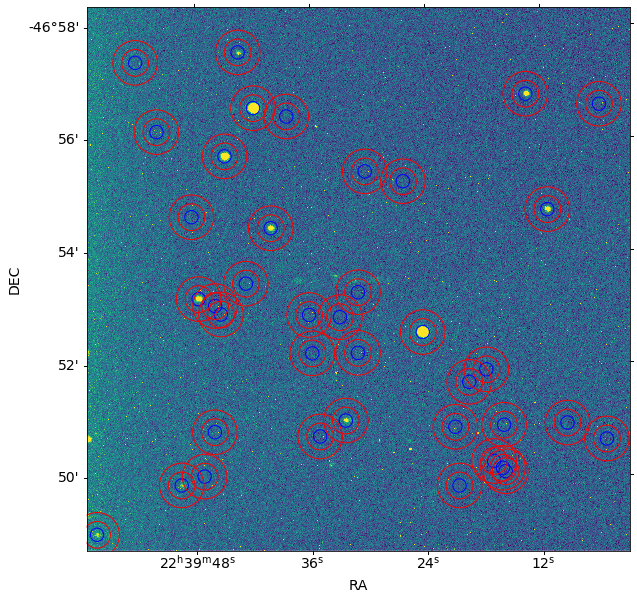

In [14]:
interval=ZScaleInterval()
vmin, vmax = interval.get_limits(data)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.subplot(projection=wcs)

img = ax.imshow(data, norm=norm) #cmap='gray'
apers = aperturas.to_pixel(wcs=wcs).plot(color='b')
ani = anillos.to_pixel(wcs=wcs).plot(color='r')

ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)
ax.tick_params(labelsize=14)
plt.show()

In [19]:
del hdus_l
del hdus_l50

NameError: name 'hdus_l' is not defined

In [12]:
fot_tabla = utilidades.Fotometria(imagenes, aperturas, anillos, forzar_escritura=True)

Las nuevas tablas quedaron guardadas en el directorio Tablas


In [13]:
fot_tabla[:5]

FNAME,MJD,DATE,s1,merr1,s2,merr2,s3,merr3,s4,merr4,s5,merr5,s6,merr6,s7,merr7,s8,merr8,s9,merr9,s10,merr10,s11,merr11,s12,merr12,s13,merr13,s14,merr14,s15,merr15,s16,merr16,s17,merr17,s18,merr18,s19,merr19,s20,merr20,s21,merr21,s22,merr22,s23,merr23,s24,merr24,s25,merr25,s26,merr26,s27,merr27,s28,merr28,s29,merr29,s30,merr30,s31,merr31,s32,merr32,s33,merr33,s34,merr34,s35,merr35,s36,merr36,s37,merr37,s38,merr38,s39,merr39
bytes15,float64,bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Vv0001w.fits,58756.030185,2019-09-30T00:43:27.984,16.02497,0.003434865,17.458331,0.0035471183,14.748751,0.0034133487,16.049598,0.0035342325,11.918663,0.0016554746,17.320275,0.003621862,16.986361,0.0035435259,13.2585,0.0025602539,17.248769,0.003532581,16.753579,0.0035826029,14.859654,0.0034121774,17.074064,0.0035669069,14.762908,0.0032815398,16.907575,0.0035753181,17.316264,0.0037068679,14.441863,0.0031423233,16.109469,0.003578783,16.701438,0.0035376625,13.970457,0.0029516441,14.727491,0.0032555742,11.613416,0.0014695609,16.252938,0.0035187693,16.671916,0.0035505255,16.033456,0.0035306947,15.346757,0.0035373539,14.952223,0.003293491,16.55909,0.0035840383,16.330374,0.0035576362,17.205628,0.0036196254,16.603905,0.0035194764,16.582329,0.003538513,16.252235,0.0035705348,16.651817,0.0036115524,16.234501,0.0035450788,16.571017,0.0035939713,17.560019,0.0035558533,16.34723,0.0035814678,16.407893,0.0035702849,13.572741,0.024889477
Vv0002w.fits,58756.032454,2019-09-30T00:46:44.026,15.650981,0.0033652843,17.412934,0.0034260414,14.459724,0.0031249463,15.634734,0.0034195616,11.612085,0.0014473581,17.133677,0.0034153123,17.093136,0.003359465,12.908578,0.0022513253,16.6219,0.0033792557,16.251146,0.0033606832,14.543105,0.0030747056,16.842088,0.0034390094,14.497654,0.0030347099,16.551133,0.0034261696,16.923815,0.0034683999,14.120408,0.0029401801,15.706287,0.0033347513,16.6104,0.0034231402,13.68122,0.0027641507,14.38843,0.0030510859,11.336679,0.0013066515,15.813057,0.0033988768,16.34986,0.0034143282,15.672099,0.0033583182,15.054915,0.0032536045,14.663475,0.0031635318,18.03149,0.0035337786,15.975939,0.0034134843,16.663626,0.0034589703,16.522618,0.0033082258,16.183448,0.0034075703,15.848182,0.0033355961,18.348747,0.0036326632,16.212142,0.0034382509,16.126401,0.0034337889,16.857862,0.0034158998,15.97736,0.0033344805,16.381542,0.0033576637,13.546273,0.024114458
Vv0003w.fits,58756.036319,2019-09-30T00:52:17.962,15.646482,0.0032636139,nan,0.0033478342,14.453447,0.0031136586,15.733661,0.0034211014,11.609189,0.0014472559,17.20652,0.0034875587,nan,0.0034530439,12.940529,0.0022787069,16.717918,0.0033757755,16.357426,0.003367588,14.537561,0.0031246756,17.287116,0.0034557747,14.450824,0.003079247,16.395191,0.0033350146,16.508777,0.0034423801,14.134579,0.0029343723,15.786922,0.0033856511,15.362637,0.0032008221,13.673086,0.0027386644,14.362336,0.0030336069,11.396151,0.0013379891,15.960909,0.0033790249,16.626862,0.0034285346,15.731635,0.00334471,15.075715,0.0032492418,14.666764,0.0031396637,21.697854,0.0035198734,15.929967,0.0032377631,16.803537,0.0034628114,16.258224,0.0033752226,16.299833,0.0034138124,21.935415,0.0035433606,20.363545,0.0035146939,16.353853,0.0034503026,16.373565,0.0034541383,16.7758,0.0033310149,15.926216,0.0033259687,16.367673,0.0034388519,15.802078,0.00328985
Vv0004w.fits,58756.037442,2019-09-30T00:53:54.989,15.701221,0.0032919417,17.465068,0.0033369067,14.570795,0.0031657425,15.667977,

In [14]:
tv1 = Table.read('Tablas/Vv0001w.ecsv')
tv1[:5]

id,xcenter,ycenter,celestial_center,aperture_sum,aper_bkg,aper_sum_bkgsub,inst_mag,inst_mag_err
,pix,pix,"deg,deg",,,,,
int64,float64,float64,object,float64,float64,float64,float64,float64
1,284.05536,938.37246,"339.9309116332097,-46.95896346604986",78053.26,74162.701,3890.5589,16.02497,0.003434865
2,90.942479,918.67666,"339.9753472928264,-46.95607035548032",77390.367,76351.242,1039.1243,17.458331,0.0035471183
3,826.00449,860.62109,"339.8063180584209,-46.946100185950634",85007.224,72403.481,12603.743,14.748751,0.0034133487
4,964.78356,841.64807,"339.774384859963,-46.94292648511229",76650.41,72847.108,3803.3018,16.049598,0.0035342325
5,312.98377,833.36804,"339.9244439002713,-46.9424540551947",245189.57,74371.055,170818.52,11.918663,0.0016554746


In [15]:
fot_tabla.show_in_browser(jsviewer=True)

In [16]:
fot_tabla.write('fotometria.csv', overwrite=True)